##### **Before starting ...**

Checking we are using frugal-notebooks-env conda environment

In [1]:
!which python

/Users/a.villa.massone/miniconda3/envs/frugal-notebooks-env/bin/python


Checking the python version is 3.9 (compatibility with frugal AI codebase)

In [2]:
!python --version

Python 3.9.21


Checking the pytorch version is > 1.12+ (compatibility with MPS)

In [3]:
import torch
print(torch.__version__)

2.5.1.post201


Imports

In [4]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# Using LLMs

## 1. **Dataset exploration**

**Loading the dataset**

In [5]:
df = pd.read_parquet("hf://datasets/QuotaClimat/frugalaichallenge-text-train/train.parquet")

In [6]:
df = df[['quote', 'label']]
df.head()

,quote,label
0,"There is clear, compelling evidence that many ...",5_science_unreliable
1,"For most of the Holocene (last 10k years), sea...",1_not_happening
2,"China, which hosts U.N. climate talks next wee...",4_solutions_harmful_unnecessary
3,And the fabricated documents (which Dr. Mann a...,0_not_relevant
4,It's going to be 42 here today and the hottest...,1_not_happening


**The label have 8 classes**

In [7]:
print('unique values:')
print('label\n', df['label'].unique())

unique values:
label
 ['5_science_unreliable' '1_not_happening'
 '4_solutions_harmful_unnecessary' '0_not_relevant' '6_proponents_biased'
 '7_fossil_fuels_needed' '2_not_human' '3_not_bad']


**We might need to crop for max tokens / clarity of prompt**

In [8]:
df['text_length'] = df['quote'].str.len()
print(df['text_length'].describe())

count    6091.000000
mean      293.528485
std       258.330755
min        19.000000
25%       139.000000
50%       228.000000
75%       365.000000
max      4703.000000
Name: text_length, dtype: float64


In [9]:
fig = px.histogram(df, x='text_length', nbins=50)
fig.update_layout(width=800, height=400, title="Sentence Length Distribution")
fig.show(renderer='iframe')

In [10]:
threshold = np.percentile(df['text_length'], 95)
threshold

722.5

In [11]:
long_quotes = df[df['text_length'] > threshold]
print('Number of quotes above threshold: ', long_quotes.shape[0])

Number of quotes above threshold:  305


In [12]:
df['truncated_quote'] = df['quote'].str.slice(0, int(threshold))
df.head()

,quote,label,text_length,truncated_quote
0,"There is clear, compelling evidence that many ...",5_science_unreliable,277,"There is clear, compelling evidence that many ..."
1,"For most of the Holocene (last 10k years), sea...",1_not_happening,279,"For most of the Holocene (last 10k years), sea..."
2,"China, which hosts U.N. climate talks next wee...",4_solutions_harmful_unnecessary,286,"China, which hosts U.N. climate talks next wee..."
3,And the fabricated documents (which Dr. Mann a...,0_not_relevant,146,And the fabricated documents (which Dr. Mann a...
4,It's going to be 42 here today and the hottest...,1_not_happening,123,It's going to be 42 here today and the hottest...


## 2. **Baseline**

In [13]:
# mistral, phi2, qwen

selected_model = "mistral"

### **Model set-up**

In [14]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [15]:
MODEL_NAMES = {
    "mistral": "mistralai/Mistral-7B-Instruct-v0.1",
    "phi2": "microsoft/phi-2",
    "qwen": "Qwen/Qwen2.5-0.5B",
    "deepseek": "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
}
# deepseek-ai/DeepSeek-R1-Distill-Qwen-7B
# "Qwen/Qwen2.5-7B"
# "Qwen/Qwen2.5-0.5B"
# "Qwen/Qwen2.5-1.5B"

CLASS_LABELS = [
    "0_not_relevant",
    "1_not_happening",
    "2_not_human",
    "3_not_bad",
    "4_solutions_harmful_unnecessary",
    "5_science_unreliable",
    "6_proponents_biased",
    "7_fossil_fuels_needed"
]

In [16]:
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

def load_model(model_name):
    llm = HuggingFaceEndpoint(
        repo_id=model_name,
        task="text-generation",
        max_new_tokens=512,
        do_sample=False,
        repetition_penalty=1.03,
    )

#    chat_model = ChatHuggingFace(llm=llm)
    return llm

**Loading the model**

In [17]:
%%time
model_name = MODEL_NAMES[selected_model]
tokenizer, model = load_model(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 10.8 s, sys: 7.14 s, total: 17.9 s
Wall time: 28.5 s


In [18]:
!ls ~/.cache/huggingface/hub/

models--Qwen--Qwen2.5-0.5B
models--Qwen--Qwen2.5-7B
models--deepseek-ai--DeepSeek-R1-Distill-Qwen-1.5B
models--mistralai--Mistral-7B-Instruct-v0.1
version.txt


In [19]:
!du -sh ~/.cache/huggingface/hub/models--mistralai--Mistral-7B-Instruct-v0.1

 13G	/Users/a.villa.massone/.cache/huggingface/hub/models--mistralai--Mistral-7B-Instruct-v0.1


In [20]:
# to clear the cache
# from huggingface_hub.utils import hf_hub_download
# hf_hub_download.clear_cache()

In [21]:
tokenizer

LlamaTokenizerFast(name_or_path='mistralai/Mistral-7B-Instruct-v0.1', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [22]:
model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
     

### **Prompt**

# minimal

def create_prompt(text):
    return f"""
<instruction>
Classify this statement into ONE climate change category (0-7). Respond STRICTLY with only the corresponding number.
</instruction>

<categories>
0 - Not relevant to climate change:
1 - Climate change is not happening:
2 - Climate change is not caused by humans:
3 - Climate change is not bad:
4 - Climate solutions are harmful:
5 - Climate science is unreliable:
6 - Climate actors are untrustworthy:
7 - Fossil fuels are essential:
</categories>

<statement>
{text}
</statement>

Category number:"""

def create_prompt(text):
    return f"""
<instruction>
Classify this statement into ONE climate change category (0-7). Respond STRICTLY with only the corresponding number.
</instruction>

<categories>
0 - Not relevant to climate change : 
No relevant claim detected or claims that don't fit other categories

1 - Climate change is not happening : 
Claims denying the occurrence of global warming and its effects - Global warming is not happening. 
Climate change is NOT leading to melting ice (such as glaciers, sea ice, and permafrost), increased extreme weather, or rising sea levels. Cold weather also shows that climate change is not happening

2 - Climate change is not caused by humans.
Claims denying human responsibility in climate change.
Greenhouse gases from humans are not the causing climate change.

3 - Climate change is not bad.
Claims minimizing or denying negative impacts of climate change.
The impacts of climate change will not be bad and might even be beneficial.

4 - Solutions to climate change are bad.
Claims against climate solutions.
Climate solutions are harmful or unnecessary

5 - Science is unreliable.
Claims questioning climate science validity
Climate science is uncertain, unsound, unreliable, or biased.

6 - Climate activists are bad.
Claims attacking climate scientists and activists
Climate scientists and proponents of climate action are alarmist, biased, wrong, hypocritical, corrupt, and/or politically motivated.

7 - Fossil fuels are a necessity.
Claims promoting fossil fuel necessity
We need fossil fuels for economic growth, prosperity, and to maintain our standard of living.
</categories>

<statement>
{text}
</statement>

Category number:"""

def create_prompt(text):
    return f"""
<instruction>
Your objective is to detect climate disinformation categories based on text from news articles.
Classify the <statement> into a <category> (0-7). 
Respond STRICTLY with only the corresponding number.
</instruction>

<categories>
0 - Statement is not relevant to climate change.
1 - Statement denies or minimize the existence of Climate change.
2 - Statement denies or minimize Human responsibility in climate change.
3 - Statement denies or minimize the negative impact of climate change.
4 - Statement challenges solutions to climate change.
5 - Statement challenges scientific evidence.
6 - Statement challenges climate actors' credibility/motives.
7 - Suggests fossil fuels are good
</categories>

<statement>
{text}
</statement>

Category number:"""

def create_prompt(text):
    return f"""
<instruction>
Your objective is to detect climate disinformation categories based on text from news articles.
Classify the <statement> into a <category> (0-7). 
Respond STRICTLY with only the corresponding number.
</instruction>

<categories>
0 - Not relevant to climate change:
No relevant climate-related claims detected, or claims that don't fit other categories
\"New sports stadium approved\" | \"Latest smartphone features\"

1 - Climate change is not happening:
Denies global warming occurrence or its impacts.
(e.g., rejects links to melting ice, extreme weather, sea level rise, or uses cold weather as counter-evidence).
\"Global warming stopped in 2016\" | \"Record cold proves no climate change\"

2 - Human activity is not causing climate change:
Claims denying human responsibility in climate change.
Attributes climate change primarily to natural causes, denying anthropogenic greenhouse gas influence.
\"CO2 doesn't affect climate\" | \"Climate changes are natural cycles\"

3 - Climate change may not be that bad:
Claims minimizing or denying negative impacts of climate change or even claims benefits from climate change.
\"Warmer winters will be better\" | \"CO2 helps plant growth\"

4 - Solutions to climate change could be bad:
Opposes mitigation strategies as unnecessary, harmful, or counterproductive.
\"Solar power ruins economies\" | \"EVs cause more pollution\"

5 - Science is bad:
Challenges scientific consensus, methods, or motives in climate research.
Claims questioning climate science validity
Climate science is uncertain, unsound, unreliable, or biased.
\"Climate models are guesses\" | \"Temperature data is fake\"

6 - Climate actors are bad:
Attacks credibility/motives of scientists, activists, or institutions promoting climate action.
\"Scientists are lying for grants\" | \"Activists want to control us\"

7 - Fossil fuels are good:
Asserts fossil fuels are critical for economic stability and quality of life.
\"Oil is essential for progress\" | \"Coal keeps lights on\"
</categories>

<statement>
{text}
</statement>

Category number:"""

In [23]:
def create_prompt(text):
    return f"""
<instruction>
Classify the following statement into one of these 8 categories:
Respond STRICTLY with only the corresponding number (0-7).
</instruction>

<categories>
0 - Not relevant: No climate-related claims or doesn't fit other categories
1 - Denial: Claims climate change is not happening
2 - Attribution denial: Claims human activity is not causing climate change
3 - Impact minimization: Claims climate change impacts are minimal or beneficial
4 - Solution opposition: Claims solutions to climate change are harmful
5 - Science skepticism: Challenges climate science validity or methods
6 - Actor criticism: Attacks credibility of climate scientists or activists
7 - Fossil fuel promotion: Asserts importance of fossil fuels
</categories>

<statement>
Statement: "{text}"
</statement>

Category number:"""

### **Prediction function**

In [24]:
from codecarbon import EmissionsTracker

def classify_text(text, tokenizer, model):
    prompt = create_prompt(text)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    tracker = EmissionsTracker(log_level="error")
    tracker.start()
    
    with torch.no_grad():
        outputs = model.generate(
            inputs.input_ids,
            max_new_tokens=2,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    inference_emissions = tracker.stop()
    inference_time = tracker.final_emissions_data.duration
    inference_energy_conso = tracker.final_emissions_data.energy_consumed

    inf_efficiency_metrics_df = pd.DataFrame.from_dict([{
        "sample_latency_sec": inference_time,
        "sample_energy_conso_kWh": inference_energy_conso,
        "sample_emissions_kgCO2eq": inference_emissions
    }])

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return response, inf_efficiency_metrics_df

In [25]:
def parse_output(response):
    prediction = response.split("Category number:")[-1].strip()
    prediction = ''.join(filter(str.isdigit, prediction))
    
    if prediction.isdigit() and int(prediction) in range(8):
        return CLASS_LABELS[int(prediction)]
    return "error"

### **Testing on a single sample**

In [26]:
model_name

'mistralai/Mistral-7B-Instruct-v0.1'

In [27]:
print(f"Model device: {model.device}")

Model device: mps:0


**Sample**

In [28]:
sample_text = df['quote'][0]
sample_text

'There is clear, compelling evidence that many of the major conclusions of the IPCC, your new religions constantly-changing Holy Book, are based on evidence that has been fabricated. The hockey stick graph that purported to abolish the mediaeval warm period is just one example.'

**Inference**

In [29]:
single_raw_prediction, single_metrics_df = classify_text(sample_text, tokenizer, model)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [30]:
print('Raw prediction:\n\n', single_raw_prediction)

single_prediction = parse_output(single_raw_prediction)
print(f'Quote:\n{sample_text}')
print(f'\nPrediction: {single_prediction}')
print(f"True label: {df['label'][0]}")
print()
single_metrics_df.head()

Raw prediction:

 
<instruction>
Classify the following statement into one of these 8 categories:
Respond STRICTLY with only the corresponding number (0-7).
</instruction>

<categories>
0 - Not relevant: No climate-related claims or doesn't fit other categories
1 - Denial: Claims climate change is not happening
2 - Attribution denial: Claims human activity is not causing climate change
3 - Impact minimization: Claims climate change impacts are minimal or beneficial
4 - Solution opposition: Claims solutions to climate change are harmful
5 - Science skepticism: Challenges climate science validity or methods
6 - Actor criticism: Attacks credibility of climate scientists or activists
7 - Fossil fuel promotion: Asserts importance of fossil fuels
</categories>

<statement>
Statement: "There is clear, compelling evidence that many of the major conclusions of the IPCC, your new religions constantly-changing Holy Book, are based on evidence that has been fabricated. The hockey stick graph that 

,sample_latency_sec,sample_energy_conso_kWh,sample_emissions_kgCO2eq
0,12.382259,0.000177,0.00001


### **Testing on a larger sample size**

##### **Sample**

In [31]:
random.seed(42)
torch.manual_seed(42)

N_SAMPLES = 50

df_test = df.sample(N_SAMPLES, random_state=42)
X_test = df_test['quote'].tolist()
y_test = df_test['label'].tolist()

X_test[:5]

['Mann could be said to be the Jerry Sandusky of climate science, except for instead of molesting children, he has molested and tortured data in the service of politicized science that could have dire economic consequences for the nation and planet,” Rand Simberg wrote in\xa0National Review\xa0article in\xa02012.',
 'The reality is that the infra-red active gases act more like an umbrella providing the Earths surface with shade to keep it cool than like a greenhouse to keep it warmer. It is a much more realistic description of the infra-red active gases to call them shade gases, rather than greenhouse gases.',
 '“Late 20th century and early 21st century global warming, they show, is neither dramatic, nor unusual, nor scary. Here … are just some of the charts to prove it.”',
 'Our research has shown that the concentration of carbon dioxide in the atmosphere has no impact on global temperatures, or the climate.',
 'I am speaking only as a layman who observes that there is plenty of snow 

##### **Inference function**

In [32]:
def batch_inference(model, tokenizer, X_test):
    predictions = []
    metrics_list = []
    errors = 0
    
    for i, quote in enumerate(X_test):
        print(f'Progress : quote {i}/{len(X_test)} | {round(i/len(X_test)*100, 2)}%')
        try:
            pred, metrics_df = classify_text(quote, tokenizer, model)
            pred = parse_output(pred)
            predictions.append(pred)
            metrics_list.append(metrics_df.iloc[0])
    
            if pred == "error":
                errors += 1
        except Exception as e:
            predictions.append("error")
            errors += 1
            print(f"Error processing: {text[:50]}... -> {str(e)}")

    if metrics_list:
        batch_metrics_df = pd.DataFrame(metrics_list, columns=[
            "sample_latency_sec",
            "sample_energy_conso_kWh",
            "sample_emissions_kgCO2eq"
        ])
        inf_efficiency_metrics = {
            "total_latency_sec": np.sum(batch_metrics_df['sample_latency_sec']),
            "sample_latency_sec": np.mean(batch_metrics_df['sample_latency_sec']),
            "total_energy_conso_kWh": np.sum(batch_metrics_df['sample_energy_conso_kWh']),
            "sample_energy_conso_kWh": np.mean(batch_metrics_df['sample_energy_conso_kWh']),
            "total_emissions_kgCO2eq": np.sum(batch_metrics_df['sample_emissions_kgCO2eq'])
        }
    if errors:
        print(f"Total errors: {errors}")

    return predictions, inf_efficiency_metrics

##### **Inference**

In [33]:
model_name

'mistralai/Mistral-7B-Instruct-v0.1'

In [34]:
create_prompt('')

'\n<instruction>\nClassify the following statement into one of these 8 categories:\nRespond STRICTLY with only the corresponding number (0-7).\n</instruction>\n\n<categories>\n0 - Not relevant: No climate-related claims or doesn\'t fit other categories\n1 - Denial: Claims climate change is not happening\n2 - Attribution denial: Claims human activity is not causing climate change\n3 - Impact minimization: Claims climate change impacts are minimal or beneficial\n4 - Solution opposition: Claims solutions to climate change are harmful\n5 - Science skepticism: Challenges climate science validity or methods\n6 - Actor criticism: Attacks credibility of climate scientists or activists\n7 - Fossil fuel promotion: Asserts importance of fossil fuels\n</categories>\n\n<statement>\nStatement: ""\n</statement>\n\nCategory number:'

In [35]:
print("original dataset :", max([len(x) for x in df_test['quote'].tolist()]), 'char')
print("truncated dataset :", max([len(x) for x in df_test['truncated_quote'].tolist()]), 'char')
print("X_test :", 'original' if max([len(x) for x in X_test]) == 1133 else 'truncated')

original dataset : 1133 char
truncated dataset : 722 char
X_test : original


In [36]:
est_time = single_metrics_df['sample_latency_sec'][0] * N_SAMPLES
print(f"Estimated time to compute : {round(est_time//60)} min {round(est_time%60)} sec")

Estimated time to compute : 10 min 19 sec


In [37]:
y_pred, efficiency_metrics_df = batch_inference(model, tokenizer, X_test)

Progress : quote 0/50 | 0.0%
Progress : quote 1/50 | 2.0%
Progress : quote 2/50 | 4.0%
Progress : quote 3/50 | 6.0%
Progress : quote 4/50 | 8.0%
Progress : quote 5/50 | 10.0%
Progress : quote 6/50 | 12.0%
Progress : quote 7/50 | 14.0%
Progress : quote 8/50 | 16.0%
Progress : quote 9/50 | 18.0%
Progress : quote 10/50 | 20.0%
Progress : quote 11/50 | 22.0%
Progress : quote 12/50 | 24.0%
Progress : quote 13/50 | 26.0%
Progress : quote 14/50 | 28.0%
Progress : quote 15/50 | 30.0%
Progress : quote 16/50 | 32.0%
Progress : quote 17/50 | 34.0%
Progress : quote 18/50 | 36.0%
Progress : quote 19/50 | 38.0%
Progress : quote 20/50 | 40.0%
Progress : quote 21/50 | 42.0%
Progress : quote 22/50 | 44.0%
Progress : quote 23/50 | 46.0%
Progress : quote 24/50 | 48.0%
Progress : quote 25/50 | 50.0%
Progress : quote 26/50 | 52.0%
Progress : quote 27/50 | 54.0%
Progress : quote 28/50 | 56.0%
Progress : quote 29/50 | 58.0%
Progress : quote 30/50 | 60.0%
Progress : quote 31/50 | 62.0%
Progress : quote 32/50 

In [38]:
eff_time = efficiency_metrics_df['total_latency_sec']
print(f"Effective time to compute : {round(eff_time//60)} min {round(eff_time%60)} sec")

Effective time to compute : 1 min 38 sec


**Efficiency Metrics**

In [39]:
efficiency_metrics_df

{'total_latency_sec': 97.7060661315918,
 'sample_latency_sec': 1.954121322631836,
 'total_energy_conso_kWh': 0.001397700557013353,
 'sample_energy_conso_kWh': 2.795401114026706e-05,
 'total_emissions_kgCO2eq': 8.111415412571292e-05}

**Performance Metrics**

##### Functions

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import numpy as np

def evaluation(X_test, y_test, y_pred):
    # Store results in a DataFrame
    results = pd.DataFrame({
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred
    })
    results["correct"] = results["y_test"] == results["y_pred"]

    # Compute overall performance breakdown
    correct = np.sum(results["correct"])
    errors = np.sum(results["y_pred"] == 'error')
    incorrect = len(results) - correct - errors
    
    performance = pd.DataFrame({
        'Outcome': ['Correct', 'Incorrect', 'Error'],
        'Count': [correct,incorrect,errors]
        })

    # Compute overall accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Get category labels (sorted for consistency)
    category_names = sorted(pd.Series(y_test).unique())

    # Compute per-class metrics
    class_accuracy = results.groupby("y_test")["correct"].mean().reindex(category_names, fill_value=0).values
    precision = precision_score(y_test, y_pred, average=None, labels=category_names, zero_division=0)
    recall = recall_score(y_test, y_pred, average=None, labels=category_names, zero_division=0)
    f1 = f1_score(y_test, y_pred, average=None, labels=category_names, zero_division=0)

    # Store per-category metrics
    metrics_df = pd.DataFrame({
        "Category": category_names,
        "Accuracy": class_accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

    return results, accuracy, metrics_df, performance

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred):
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    labels = np.unique(y_test)  # Unique class labels
    
    # Compute TP, FP, FN, TN for each class
    tp = np.diag(cm)  # True Positives (diagonal)
    fp = cm.sum(axis=0) - tp  # Column sum minus TP
    fn = cm.sum(axis=1) - tp  # Row sum minus TP
    tn = cm.sum() - (tp + fp + fn)  # Total samples - (TP + FP + FN)
    
    print('Sample size:', N_SAMPLES)
    print(f'True positives: \t{tp.sum()}')
    print(f'False positives:\t{fp.sum()}')
    print(f'False negatives:\t{fn.sum()}')
    
    # 📊 3️⃣ **Plot Full Multi-Class Confusion Matrix**
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Full 8-Class Confusion Matrix")
    plt.show()

In [42]:
import matplotlib.pyplot as plt

def plot_metrics(performance, metrics_df):
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Classification Performance Breakdown (Bar Chart)
    axes[0].bar(performance['Outcome'], performance['Count'], color=['green', 'red', 'gray'])
    axes[0].set_title("Classification Performance Breakdown", fontsize=14)
    axes[0].set_ylabel("Count", fontsize=12)
    axes[0].set_xlabel("Outcome", fontsize=12)
    
    # Line Plot for F1 Score, Precision, Recall
    categories = metrics_df['Category']
    
    axes[1].plot(categories, metrics_df['F1 Score'], marker='o', label='F1 Score')
    axes[1].plot(categories, metrics_df['Precision'], marker='s', label='Precision')
    axes[1].plot(categories, metrics_df['Recall'], marker='^', label='Recall')
    
    axes[1].axhline(y=accuracy, color='r', linestyle='--', label=f'Accuracy ({accuracy:.2f})')
    
    axes[1].set_xlabel("Category", fontsize=12)
    axes[1].set_ylabel("Score", fontsize=12)
    axes[1].set_title("Evaluation Metrics per Category", fontsize=14)
    axes[1].set_xticks(range(len(categories)))
    axes[1].set_xticklabels(categories, rotation=45, ha="right")
    axes[1].legend()
    axes[1].grid(True)
    
    # Adjust layout and show
    plt.tight_layout()
    plt.show()

##### **Summary**

In [43]:
results_df, accuracy, metrics_df, performance = evaluation(X_test, y_test, y_pred)

In [44]:
results_df.head()

,X_test,y_test,y_pred,correct
0,Mann could be said to be the Jerry Sandusky of...,6_proponents_biased,6_proponents_biased,True
1,The reality is that the infra-red active gases...,2_not_human,5_science_unreliable,False
2,“Late 20th century and early 21st century glob...,3_not_bad,3_not_bad,True
3,Our research has shown that the concentration ...,2_not_human,2_not_human,True
4,I am speaking only as a layman who observes th...,1_not_happening,0_not_relevant,False


In [45]:
performance

,Outcome,Count
0,Correct,25
1,Incorrect,25
2,Error,0


In [46]:
print(f'Accuracy: {accuracy}\n')

metrics_df.round(3)

Accuracy: 0.5



,Category,Accuracy,Precision,Recall,F1 Score
0,0_not_relevant,0.833,0.417,0.833,0.556
1,1_not_happening,0.200,0.333,0.200,0.250
2,2_not_human,0.167,1.000,0.167,0.286
3,3_not_bad,0.625,0.625,0.625,0.625
4,4_solutions_harmful_unnecessary,0.000,0.000,0.000,0.000
5,5_science_unreliable,0.556,0.625,0.556,0.588
6,6_proponents_biased,0.571,0.667,0.571,0.615
7,7_fossil_fuels_needed,1.000,0.333,1.000,0.500


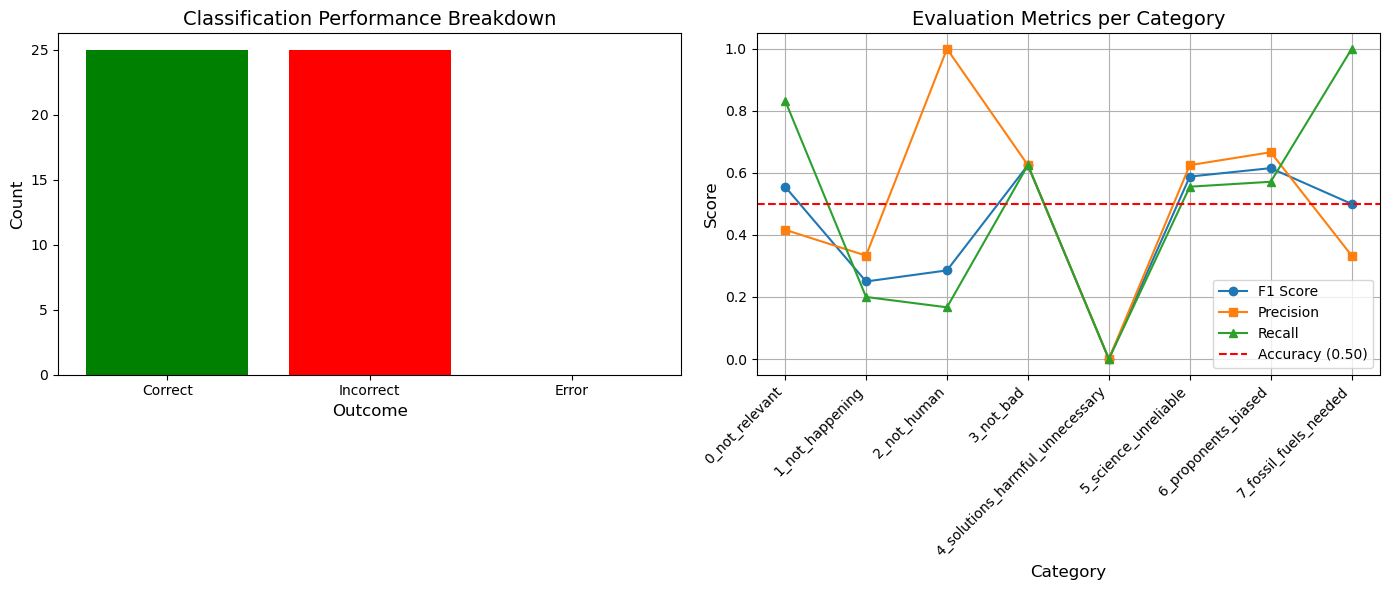

In [47]:
plot_metrics(performance, metrics_df)

In [48]:
r = pd.concat([
    results_df['y_test'].value_counts().sort_index(),
    results_df['y_pred'].value_counts().sort_index()
], axis=1)
r.columns = ['y_test', 'y_pred']
r

,y_test,y_pred
0_not_relevant,6,12.0
1_not_happening,5,3.0
2_not_human,6,1.0
3_not_bad,8,8.0
4_solutions_harmful_unnecessary,5,NaN
5_science_unreliable,9,8.0
6_proponents_biased,7,6.0
7_fossil_fuels_needed,4,12.0


Sample size: 50
True positives: 	25
False positives:	25
False negatives:	25


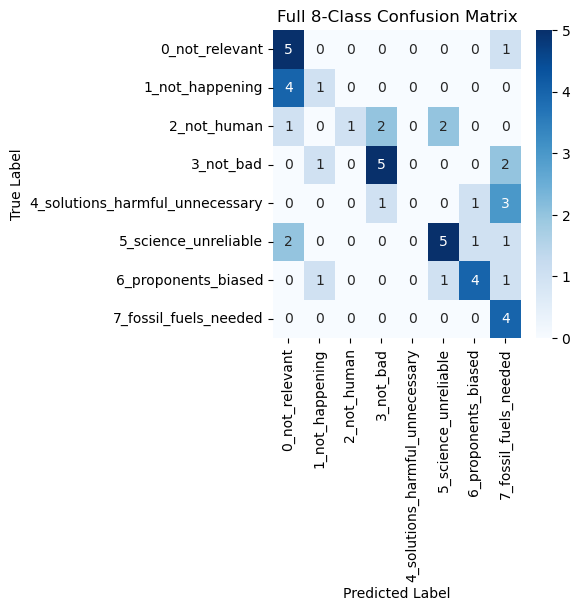

In [49]:
plot_confusion_matrix(y_test, y_pred)

## **Let's save the results**

In [50]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
timestamp

'2025-01-31_17:52:09'

In [51]:
filename = (
    "metrics/"
    f"{'_'.join(model_name.split('/'))}"
    f"_accuracy_{int(accuracy * 100)}"
    f"_dt_{timestamp.replace(':', '').replace('-', '')}"
    ".json"
)
filename

'metrics/mistralai_Mistral-7B-Instruct-v0.1_accuracy_50_dt_20250131_175209.json'

In [52]:
note = "Baseline SLM, step by step, quote cropping"

In [53]:
# ajouter category metrics

os.makedirs("metrics", exist_ok=True)

data = {
    "model_name": model_name,
    "timestamp": timestamp,
    "note": note,
    "test_size" : N_SAMPLES,
    "quote_max_len": (max([len(x) for x in X_test])),
    "test_accuracy": accuracy,

    "total_latency_sec": efficiency_metrics_df['total_latency_sec'],
    "total_energy_conso_kWh": efficiency_metrics_df['total_energy_conso_kWh'],

    "sample_latency_sec": efficiency_metrics_df['sample_latency_sec'],
    "sample_energy_conso_kWh": efficiency_metrics_df['sample_energy_conso_kWh'],
    "total_emissions_kgCO2eq": efficiency_metrics_df['total_emissions_kgCO2eq'],

    "class_performance_metrics": metrics_df.to_dict(orient="records"),
    "prompt": create_prompt('')
}
data

{'model_name': 'mistralai/Mistral-7B-Instruct-v0.1',
 'timestamp': '2025-01-31_17:52:09',
 'note': 'Baseline SLM, step by step, quote cropping',
 'test_size': 50,
 'quote_max_len': 1133,
 'test_accuracy': 0.5,
 'total_latency_sec': 97.7060661315918,
 'total_energy_conso_kWh': 0.001397700557013353,
 'sample_latency_sec': 1.954121322631836,
 'sample_energy_conso_kWh': 2.795401114026706e-05,
 'total_emissions_kgCO2eq': 8.111415412571292e-05,
 'class_performance_metrics': [{'Category': '0_not_relevant',
   'Accuracy': 0.8333333333333334,
   'Precision': 0.4166666666666667,
   'Recall': 0.8333333333333334,
   'F1 Score': 0.5555555555555556},
  {'Category': '1_not_happening',
   'Accuracy': 0.2,
   'Precision': 0.3333333333333333,
   'Recall': 0.2,
   'F1 Score': 0.25},
  {'Category': '2_not_human',
   'Accuracy': 0.16666666666666666,
   'Precision': 1.0,
   'Recall': 0.16666666666666666,
   'F1 Score': 0.2857142857142857},
  {'Category': '3_not_bad',
   'Accuracy': 0.625,
   'Precision': 0.

In [54]:
import json

with open(filename, "w") as f:
    json.dump(data, f, indent=4)

print(f"Metrics saved to {filename}")

Metrics saved to metrics/mistralai_Mistral-7B-Instruct-v0.1_accuracy_50_dt_20250131_175209.json
